In [1]:
from tqdm.auto import tqdm
import torch 
from transformers import DistilBertModel
from transformers import DistilBertTokenizer
from transformers import PreTrainedTokenizer
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from torch.nn import CosineEmbeddingLoss
import sklearn
import spacy
from torch import nn
#Build up to SBERT model 

/opt/anaconda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/anaconda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/anaconda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/anaconda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
deviceNum = 0

device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")

def check_mem():
    torch.cuda.empty_cache()
    a = torch.cuda.memory_allocated(deviceNum)/1024/1024/1024
    r = torch.cuda.memory_reserved(deviceNum)/1024/1024/1024
    print("torch.cuda.memory_allocated: %fGB"%a)
    print("torch.cuda.memory_reserved: %fGB"%r)
    print("torch.cuda.memory_free: %fGB"%(r-a))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(deviceNum)/1024/1024/1024))
check_mem()


torch.manual_seed(0)

df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTrainData.csv", sep="\t")
df = df.loc[(df["url1_lang"] == "en") & (df["url2_lang"] == "en")]

#put ground truth values into a list 
df["ground_truth"] = df['Overall']

#get only the columns we need 
#TODO: do we need "pair_id"? 
leanDf = df[["ground_truth",  'text1', 'text2']].dropna()

#rescale data from (0, 4): (0, 1)
leanDf["ground_truth"] = 1 - ((leanDf["ground_truth"] - 1) / 3)

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [3]:
leanDf["ground_truth"]

0       0.000000
1       0.111111
2       0.555556
3       0.666667
4       0.916667
          ...   
2871    0.333333
2872    0.000000
2873    1.000000
2874    1.000000
2875    1.000000
Name: ground_truth, Length: 1676, dtype: float64

In [4]:
class CustomSentListDataset(Dataset): 
    def __init__(self, inDf): 
        self.inDf = inDf 
        
    def __len__(self): 
        return len(self.inDf)
    
    def __getitem__(self, idx):
        return list(self.inDf.iloc[idx])

In [5]:
#nlp = spacy.load("en_core_web_sm", disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"])
#nlp.enable_pipe("senter")
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")

def extractSents(inList): 
    separator = nlp.pipe(inList, n_process=8)
    textList = []
    for text in tqdm(separator): 
        sentList = [str(sent) for sent in text.sents if len(sent) > 3]
        textList.append(sentList)
    return textList

#split data 
trainDf, validDf = sklearn.model_selection.train_test_split(leanDf, train_size=.9, test_size=.1)
trainDf = trainDf.reset_index(drop=True)
validDf = validDf.reset_index(drop=True)

trainDf["text1"] = extractSents(trainDf["text1"])
trainDf["text2"] = extractSents(trainDf["text2"])
validDf["text1"] = extractSents(validDf["text1"])
validDf["text2"] = extractSents(validDf["text2"])



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [6]:
trainDf["text1"]

0       [Claudius Moore, a seasoned technology executi...
1       [Tom Brady Uses Protection Stones, And Other T...
2       [CARE is an international NGO with local staff...
3       [AVANESHNI Govender was one of Scottburgh High...
4       [Success Nwogu, Abuja\n\nThe Peoples Democrati...
                              ...                        
1503    [Fort Lewis College is updating about a dozen ...
1504    [Florida high school football star hit by trai...
1505    [Woodlands program teaches proper recycling ha...
1506    [Local digest\n\nPa. gaming revenue up more th...
1507    [FILE PHOTO: Buildings are engulfed in fog in ...
Name: text1, Length: 1508, dtype: object

In [7]:
sentCutoff = 60
 
trainDf["text1"] = trainDf["text1"].apply(lambda x: x[:sentCutoff])
trainDf["text2"] = trainDf["text2"].apply(lambda x: x[:sentCutoff])

validDf["text1"] = validDf["text1"].apply(lambda x: x[:sentCutoff])
validDf["text2"] = validDf["text2"].apply(lambda x: x[:sentCutoff])


(array([186., 321., 296., 192., 128.,  97.,  66.,  44.,  42., 136.]),
 array([ 1. ,  6.9, 12.8, 18.7, 24.6, 30.5, 36.4, 42.3, 48.2, 54.1, 60. ]),
 <a list of 10 Patch objects>)

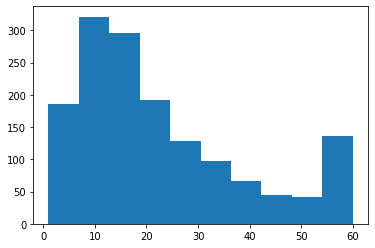

In [8]:
plt.hist(trainDf["text1"].apply(len))

In [9]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')

def getLoader(inDf, batchSize): 
    inDf["text1"] = inDf["text1"].apply(lambda x: tokenizer.batch_encode_plus(x, max_length=150, padding="max_length", truncation=True, return_tensors="pt"))
    inDf["text2"] = inDf["text2"].apply(lambda x: tokenizer.batch_encode_plus(x, max_length=150, padding="max_length", truncation=True, return_tensors="pt"))
    
    inDf["text1_input_ids"] = inDf["text1"].apply(lambda x: x["input_ids"])
    inDf["text2_input_ids"] = inDf["text2"].apply(lambda x: x["input_ids"])
    
    inDf["text1_attention_mask"] = inDf["text1"].apply(lambda x: x["attention_mask"])
    inDf["text2_attention_mask"] = inDf["text2"].apply(lambda x: x["attention_mask"])
    
    #inDf["ground_truth"] = inDf["ground_truth"].apply(lambda x: x))
    
    dataset = CustomSentListDataset(inDf[["ground_truth", "text1_input_ids", "text1_attention_mask","text2_input_ids", "text2_attention_mask"]])
    
    # convert dataset features to PyTorch tensors
    #dataset.set_format(type='torch', columns=inDf.columns())
    loader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True)
    return [dataset, loader]

trainData, trainLoader = getLoader(trainDf, 1)
validData, validLoader = getLoader(validDf, 1)


15.0
20.405835543766578


605.0

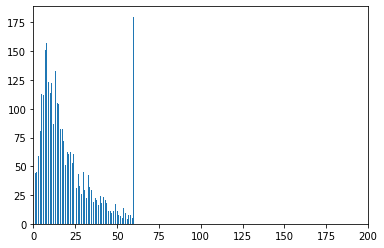

In [10]:
len1 = [len(item) for item in trainDf["text1_input_ids"]]
len2 = [len(item) for item in trainDf["text2_input_ids"]]

allLens = len1 + len2
plt.hist(allLens, bins=100)
plt.xlim([0, 200])
print(np.median(allLens))
print(np.mean(allLens))

#look at the length of sentences multiplied together 
multLen = np.empty([len(len1), len(len2)])
for i, a in enumerate(len1): 
    for j, b in enumerate(len2): 
        multLen[i, j] = a*b
multLen = multLen.flatten()

#90th quantile is 1148 
np.quantile(multLen, .9)
np.quantile(multLen, .8)
#so go with 800? 

In [11]:

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(token_embeddings, attention_mask):
     #First element of model_output contains all token embeddings
    #print(attention_mask.unsqueeze(-1).shape)
    #print(token_embeddings.size())
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [12]:
class MyModel(nn.Module):
    def __init__(self, flatCutoff):
        super(MyModel,self).__init__()
        self.model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
        self.cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
        self.flatCutoff = flatCutoff
        self.ReLU = nn.ReLU()
        self.l1 = nn.Linear(flatCutoff, 1000).to(device)
        self.l2 = nn.Linear(1000, 500).to(device)
        self.l3 = nn.Linear(500, 250).to(device)
        self.l4 = nn.Linear(250, 1).to(device)
        self.loss_func = torch.nn.MSELoss(reduction="mean")
        
    def mean_pooling(self, token_embeddings, attention_mask): 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, inputs_ids_a, attention_a, inputs_ids_b, attention_b, gt): 
        
        u = self.model(inputs_ids_a, attention_mask=attention_a)[0]  # all token embeddings B
        #try to clear up memory and keep only the sentence embeddings 
        del inputs_ids_a

        sents_u = mean_pooling(u, attention_a)
        del attention_a
        del u 
        
        v = self.model(inputs_ids_b, attention_mask=attention_b)[0]  # all token embeddings B
        del inputs_ids_b

        sents_v = self.mean_pooling(v, attention_b)
        del attention_b
        del v
        
        #get similarity matrix for sentences between the documents 
        sims = np.empty([sents_u.shape[0], sents_v.shape[0]])
        for i, uSent in enumerate(sents_u): 
            for j, vSent in enumerate(sents_v):
                sims[i, j] = self.cos(uSent, vSent)

        #flatten down to one dimension 
        sims = sims.flatten()
        
        # we know that if we get the first 800 we will have between 
        # 80% and 90% of our possible sentence combinations fully included without cutting them off 
        sims_cut = torch.Tensor(sims[:self.flatCutoff]).to(device)

        #pad on the right out to len of 800
        sims_padded = torch.nn.functional.pad(sims_cut, [0, self.flatCutoff-sims_cut.shape[0]])

        del sims_cut

        #first attempt is a single linear layer
        #maybe linear combination of output is sufficient? 
        #go from 4000 > 500 > 1
        out = self.l1(sims_padded)
        out = self.ReLU(out)
        out = self.l2(out)
        out = self.ReLU(out)
        out = self.l3(out)
        out = self.ReLU(out)
        pred = self.l4(out)
        
        
        #print(vPredSim)
        loss = self.loss_func(pred, gt)
        
        return [loss, pred, gt] 


In [13]:
model = MyModel(4000).to(device)

trainBatch = 1

# we would initialize everything first
optim = torch.optim.Adam(model.parameters(), lr=2e-5)

# and setup a warmup for the first ~10% steps
total_steps = int(len(trainData) / trainBatch)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)

In [14]:
def validation(): 
    model.eval()
    lossList = []
    preds = []
    gts = []

    for vBatch in validLoader: 
        # prepare batches and more all to the active device
        inputs_ids_a = vBatch[1][0].to(device)
        attention_a = vBatch[2][0].to(device)
        inputs_ids_b = vBatch[3][0].to(device)
        attention_b = vBatch[4][0].to(device)
        gt = vBatch[0].float().to(device)
        
        #get outputs from model 
        loss, pred, gt = model(inputs_ids_a, attention_a, inputs_ids_b, attention_b, gt)
        
        #get predictions and ground truth to compute training metrics with 
        lossList.append(float(loss))
        preds.append(float(pred))
        gts.append(float(gt))
        
    #print(vGT)
    return [lossList, preds, gts]
        

In [15]:
lossSmoothing = 20
validationFreq = 200 

#TODO: implement a cutoff on how many sentences of the article we can consider 
#TODO: put model in seperate class? How to make sure the params are updating 
trainDict = {}
lossList = []
subLossList = []
validMetrics = []
# increase from 1 epoch if need be 
for epoch in range(2):
    
    model.train()  # make sure model is in training mode
    
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(trainLoader, leave=True)
    
    for i, batch in enumerate(loop): 
        # zero all gradients on each new step
        optim.zero_grad()
        
        #in practice this doesn't seem to usually actually help but worth adding? 
        torch.cuda.empty_cache()

        #get model inputs from batch 
        inputs_ids_a = batch[1][0].to(device)
        attention_a = batch[2][0].to(device)
        inputs_ids_b = batch[3][0].to(device)
        attention_b = batch[4][0].to(device)
        gt = batch[0].float().to(device)

        #get outputs from model 
        loss, pred, gt = model(inputs_ids_a, attention_a, inputs_ids_b, attention_b, gt)
        
        subLossList.append(loss.item())
        if i % lossSmoothing == 0: 
            lossList.append(np.median(subLossList))
            subLossList = []
        
        #update weights 
        loss.backward()
        
        #validation if at correct step 
        if i % validationFreq == 0: 
            validMetrics.append(validation())
            model.train()
        
        optim.step()
        scheduler.step()

  0%|          | 0/1508 [00:00<?, ?it/s]

  0%|          | 0/1508 [00:00<?, ?it/s]

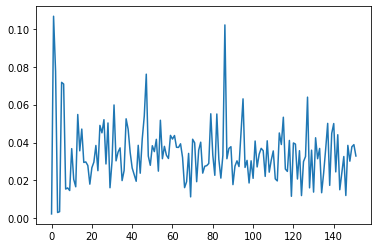

In [25]:
plt.plot(lossList)


Text(0.5, 1.0, 'Train Loss')

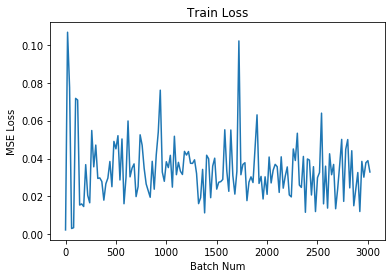

In [30]:
lossIndex = [i * lossSmoothing for i in range(len(lossList))]
plt.plot(lossIndex, lossList)
plt.xlabel("Batch Num")
plt.ylabel("MSE Loss")
plt.title("Train Loss")

In [18]:
np.array(validMetrics).shape

(16, 3, 168)

In [19]:
validDf = pd.DataFrame({"loss":[], "pred":[], "true":[], "iter":[]})
validArr = np.array(validMetrics)

iterNum = 0
corrList = []
iterList = []
for i in range(validArr.shape[0]): 
    subDf = pd.DataFrame(validArr[i].T)
    subDf.columns = ["loss", "pred", "true"]
    subDf["iter"] = [iterNum for i in range(len(subDf))]
    iterList.append(iterNum)
    iterNum += validationFreq
    validDf = pd.concat([validDf, subDf])
    corr = np.corrcoef(subDf["pred"], subDf["true"])
    corrList.append(corr[0, 1])

Text(0.5, 1.0, 'validation eval')

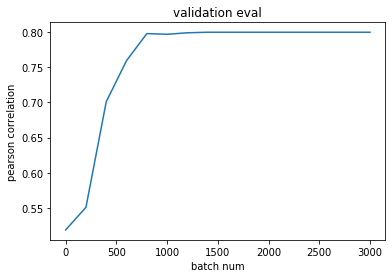

In [29]:
plt.plot(iterList, corrList)
plt.xlabel("batch num")
plt.ylabel("pearson correlation")
plt.title("validation eval")

[[1.         0.51918491]
 [0.51918491 1.        ]]
[[1.         0.55125271]
 [0.55125271 1.        ]]
[[1.         0.70083832]
 [0.70083832 1.        ]]
[[1.       0.758979]
 [0.758979 1.      ]]
[[1.         0.79723878]
 [0.79723878 1.        ]]
[[1.        0.7962994]
 [0.7962994 1.       ]]
[[1.         0.79841897]
 [0.79841897 1.        ]]
[[1.         0.79918031]
 [0.79918031 1.        ]]
[[1.         0.79918031]
 [0.79918031 1.        ]]
[[1.         0.79918031]
 [0.79918031 1.        ]]
[[1.         0.79918031]
 [0.79918031 1.        ]]
[[1.         0.79918031]
 [0.79918031 1.        ]]
[[1.         0.79918031]
 [0.79918031 1.        ]]
[[1.         0.79918031]
 [0.79918031 1.        ]]
[[1.         0.79918031]
 [0.79918031 1.        ]]
[[1.         0.79918031]
 [0.79918031 1.        ]]


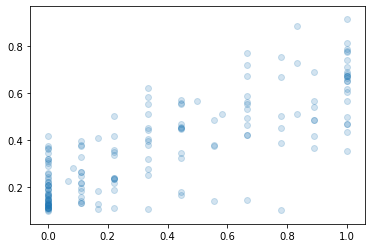

In [21]:

#print(validArr.shape)

test = validArr[1,:,:]
#np.corrcoef(test[1], test[2])

#go through each validation step
for i in range(validArr.shape[0]): 
    subDf = pd.DataFrame(validArr[i].T)
    subDf.columns = ["loss", "pred", "true"]
    corr = np.corrcoef(subDf["pred"], subDf["true"])
    print(corr)
    
plt.scatter(subDf["true"], subDf["pred"], alpha=.2)

In [22]:
validArr[0]

array([[2.26821029e-03, 1.46730542e-01, 2.22614082e-03, 2.31914385e-03,
        2.31204717e-03, 2.84160189e-02, 7.83412978e-02, 9.01614130e-01,
        9.00020957e-01, 2.41207960e-03, 1.42143741e-02, 2.26807152e-03,
        2.57409066e-01, 3.86708835e-03, 2.39863154e-03, 8.94130468e-01,
        3.57753336e-01, 1.50629103e-01, 2.35541747e-03, 2.46683531e-03,
        2.28174636e-03, 7.57760927e-02, 1.41677186e-02, 7.94852823e-02,
        3.89244780e-03, 2.27030250e-03, 3.83607810e-03, 2.33435188e-03,
        8.98125410e-01, 2.27632280e-03, 2.49437545e-03, 3.70841682e-01,
        7.02659845e-01, 3.70886832e-01, 1.40420999e-02, 8.13457742e-02,
        2.28633033e-03, 3.80429387e-01, 3.51480744e-03, 7.89421052e-02,
        3.75976227e-03, 8.95035625e-01, 2.81959057e-01, 2.25289445e-03,
        7.25628734e-02, 9.01085258e-01, 2.31977622e-03, 1.99628502e-01,
        1.57260820e-01, 1.20306842e-03, 8.92878890e-01, 5.29383600e-01,
        7.71000311e-02, 2.56620371e-03, 3.71390551e-01, 1.507853

In [23]:
validDf.loc[validDf["iter"] == 1400, "true"]

0      0.111111
1      0.111111
2      0.000000
3      0.000000
4      1.000000
         ...   
163    0.000000
164    0.555556
165    0.888889
166    1.000000
167    0.000000
Name: true, Length: 168, dtype: float64

In [24]:
#check memory 
t = torch.cuda.mem_get_info()

used = torch.cuda.memory_allocated(device="cuda:4")
#proportion of free memory 
#print("used: " used / t[1])
print("used: " + str(t[0]/t[1]))

used: 0.6814136489891832
